In [38]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import warnings
import math
import numpy as np
import seaborn as sns
from glob import glob
from scipy.optimize import curve_fit

In [39]:
# Load data

measurement_dirs = []
# measurement_dirs += glob(f"data/2024-06-17_21*/*/*/*")
# measurement_dirs += glob(f"data/2024-06-18*/*/*/*")
measurement_dirs += glob(f"data/2024-06-19_22-5*/*/*/*")
# measurement_dirs += glob(f"data_scale/*/*")
# measurement_dirs += glob(f"data_scale_rampup/*/*")

measurement_dirs = sorted(measurement_dirs)
display(measurement_dirs)

['data/2024-06-19_22-51-32/exp_scale_rampup/baseline_vanilla_cpu/0']

In [56]:
node_models = {
    "sm-gpu":[4.19542760e+01, 1.49493895e+01, 8.49503947e-05],
    "ise-knode6":[4.28145431e+01, 8.30311457e-01, 2.13227901e-04],
}

def energy_func(X, a, b, c):
    return a + b * X[:, 0] + c * X[:, 1]

def model_energy_funct(df:pd.DataFrame):
    for instance in node_models:
        df.loc[df["instance"]==instance,"wattage_estimation"] = energy_func(df[df["instance"]==instance][['cpu_usage', 'memory_usage']].values,*node_models[instance])
    return df

from scipy.stats import zscore
def measurment_processor(df:pd.DataFrame, z_score_threshold: float = 4, drop_unknown_instance:bool=True):
    data_errors = 0
    data_size = len(df)

    #print(f'{len(df[df["collection_time"] == "0"])} timeoffs')
    data_errors += len(df[df["collection_time"] == "0"])

    #time alignment - map data time to experiment time to get a relative score
    df = df.drop(df[df["collection_time"] == "0"].index)
    df["collection_time"] = pd.to_datetime(df["collection_time"],format="mixed")
    df["exp_time"] = (df["collection_time"] - df["collection_time"].min())
    df["exp_time"] = df["exp_time"].apply(lambda x:int(x.total_seconds()))
    
    
    #quality control (check if we have unknown data points (thats and issue), z-scroe > threshold) and remove
    instance_issues = df[df["instance"] == "unknown"].index
    data_errors += len(instance_issues)
    
    if drop_unknown_instance:
        print(f"dropped {len(instance_issues)} unknowns")
        df = df.drop(instance_issues)

    #calculate z-scores
    common_keys = ["wattage_kepler","wattage_scaph","cpu_usage","memory_usage","network_usage"]
    for key in common_keys:
        df[f"{key}_zscore"]  = zscore(df[key])


    for key in common_keys:
        outliers = df[df[f"{key}_zscore"].abs() > z_score_threshold].index
        #print(f"{len(outliers)} zScore")
        data_errors += len(outliers)
        df = df.drop(outliers)

    df = model_energy_funct(df)

    return df, (data_errors/data_size)

def exp_file_to_df(file:str, prefix: str) -> pd.DataFrame:
    (pr_time,pr_scale, pr_branch, pr_run, pr_name) = "/".join(file.split("/")[-5:]).split("/")
    pod_df = pd.read_csv(file)
    pod_df["exp_workload"] = pr_scale
    pod_df["exp_branch"] = pr_branch
    pod_df["exp_run_i"] = pr_run
    pod_df["exp_time"] = pr_time
    
    run_name = pr_name.replace(prefix, "").replace(".csv", "")
    scaler = pr_branch.split("_")[-1]

    pod_df["exp_run"] = run_name
    pod_df["exp_scaler"] = scaler

    pod_df["run"] = "_".join([pr_branch, pr_scale, pr_run])

    return pod_df

def measurement_file_to_df(file:str, df:pd.DataFrame, quality_warning=0.1, quality_error=0.51):
    # no risk, no fun
   

    df, error_rate = measurment_processor(df)
    if error_rate > quality_error:
        raise ValueError(f"{file} contains {int(error_rate*100)}% fauly measurments (z-score, unknowns, 0-time...)")
    if error_rate > quality_warning:
        print(f"WARNING: {file} contains quality issues, droped: {int(error_rate*100)}% of measurments")
    
    return df


def get_df_for_prefix(prefix, measurement_dirs):
    pod_files = np.concatenate([glob(f"{d}/{prefix}*") for d in measurement_dirs])
    
    loader = lambda f: measurement_file_to_df(f,exp_file_to_df(f, prefix))
        
    all_pods = pd.concat([loader(pf) for pf in pod_files])
    return all_pods

def get_stats_df_for_prefix(prefix:str, measurement_dirs:str):
    stat_files = np.concatenate([glob(f"{d}/{prefix}*") for d in measurement_dirs])
    all_stats = pd.concat([exp_file_to_df(pf,prefix) for pf in stat_files])
    #renamte colums to lowercase and without spaces
    all_stats.columns = list(map(lambda x:x.lower().replace(" ","_"),all_stats.columns.values))
    return all_stats[all_stats["name"]!= "Aggregated"]


In [41]:
all_nodes = get_df_for_prefix("measurements_node_", measurement_dirs)
all_nodes

dropped 0 unknowns


,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,...,exp_time,exp_run,exp_scaler,run,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,wattage_estimation
0,ise-knode3,2024-06-19 22:55:14,2024-06-19 22:55:14,0.050667,0.128282,0.047373,0,5,0.000000,0.000000,...,0,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,-0.601159,-0.690252,-0.614182,-0.864502,-0.617661,NaN
1,ise-knode2,2024-06-19 22:55:14,2024-06-19 22:55:14,0.041000,0.177223,0.007051,0,3,0.000000,0.000000,...,0,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,-0.601159,-0.690252,-0.644363,0.141805,-0.634868,NaN
2,ise-knode1,2024-06-19 22:55:14,2024-06-19 22:55:14,0.196667,0.123220,0.705483,0,12,0.364767,0.491504,...,0,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,-0.135270,-0.627178,-0.158341,-0.968569,-0.336816,NaN
3,ise-knode6,2024-06-19 22:55:14,2024-06-19 22:55:14,0.238667,0.093767,0.751765,46,17,2.120033,15.498791,...,0,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,2.106599,1.298686,-0.027208,-1.574167,-0.317065,43.012731
5,ise-kmaster,2024-06-19 22:55:14,2024-06-19 22:55:14,0.253667,0.236338,0.595620,0,10,0.000000,0.000000,...,0,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,-0.601159,-0.690252,0.019625,1.357271,-0.383699,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,ise-knode2,2024-06-19 23:10:53,2024-06-19 23:10:53,0.047333,0.183280,0.880673,0,4,0.000000,0.000000,...,939,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,-0.601159,-0.690252,-0.624589,0.266329,-0.262054,NaN
554,ise-knode1,2024-06-19 23:10:53,2024-06-19 23:10:53,0.306667,0.168363,0.628804,0,14,0.072800,0.094400,...,939,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,-0.508177,-0.678138,0.185101,-0.040382,-0.369538,NaN
555,ise-knode6,2024-06-19 23:10:53,2024-06-19 23:10:53,0.197667,0.093114,0.489972,44,17,2.048767,15.220922,...,939,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,2.015575,1.263027,-0.155218,-1.587600,-0.428784,42.978688
556,sm-gpu,2024-06-19 23:10:53,2024-06-19 23:10:53,0.260667,0.221747,1.438808,46,11,0.179467,15.892892,...,939,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,-0.371940,1.349260,0.041480,1.057268,-0.023873,45.851102


In [42]:
# get all pod measurements

all_pods = get_df_for_prefix("measurements_pod_", measurement_dirs)
all_pods["instance"].unique()

dropped 123 unknowns


array(['sm-gpu', 'ise-knode1'], dtype=object)

In [43]:
all_pods

,collection_time,observation_time,name,namespace,cpu_usage,memory_usage,network_usage,instance,wattage_kepler,wattage_scaph,...,exp_time,exp_run,exp_scaler,run,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,wattage_estimation
4,2024-06-19 22:55:14,2024-06-19 22:55:14,teastore-registry-0,tea-bench,0.000000,257.572864,0.000000,sm-gpu,597.2,0.143720,...,0,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,1.147383,0.477272,-0.459828,-0.992806,-0.381781,41.976157
11,2024-06-19 22:55:24,2024-06-19 22:55:24,teastore-registry-0,tea-bench,0.000000,257.572864,0.000000,sm-gpu,597.2,0.143720,...,10,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,1.147383,0.477272,-0.459828,-0.992806,-0.381781,41.976157
18,2024-06-19 22:55:34,2024-06-19 22:55:34,teastore-registry-0,tea-bench,0.049330,261.976064,0.005215,sm-gpu,597.2,0.143720,...,20,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,1.147383,0.477272,0.063126,-0.985104,-0.373936,42.713977
22,2024-06-19 22:55:44,2024-06-19 22:55:44,teastore-auth-0,tea-bench,0.000000,584.732672,0.000657,ise-knode1,22.6,0.000000,...,30,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,-1.423488,-0.409598,-0.459828,-0.420540,-0.380793,NaN
24,2024-06-19 22:55:44,2024-06-19 22:55:44,teastore-db-0,tea-bench,0.114307,98.217984,0.000000,sm-gpu,935.7,0.093831,...,30,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,2.661897,0.169420,0.751970,-1.271548,-0.381781,43.671441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,2024-06-19 23:10:53,2024-06-19 23:10:53,teastore-db-0,tea-bench,0.000000,101.220352,0.000000,sm-gpu,227.5,0.001769,...,939,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,-0.506726,-0.398679,-0.459828,-1.266297,-0.381781,41.962875
785,2024-06-19 23:10:53,2024-06-19 23:10:53,teastore-webui-0,tea-bench,0.000000,2082.562048,0.000000,sm-gpu,455.0,0.049544,...,939,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,0.511153,-0.103872,-0.459828,2.199453,-0.381781,42.131190
786,2024-06-19 23:10:53,2024-06-19 23:10:53,teastore-registry-0,tea-bench,0.000000,300.118016,0.000000,sm-gpu,455.0,0.028753,...,939,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,0.511153,-0.232168,-0.459828,-0.918386,-0.381781,41.979771
788,2024-06-19 23:10:53,2024-06-19 23:10:53,teastore-persistence-0,tea-bench,0.000000,703.627264,0.000000,sm-gpu,455.0,0.023887,...,939,19_06_2024_22_55,cpu,baseline_vanilla_cpu_exp_scale_rampup_0,0.511153,-0.262194,-0.459828,-0.212570,-0.381781,42.014049


In [44]:
all_stats = get_stats_df_for_prefix("teastore_stats.csv", measurement_dirs)


In [45]:

reliability = all_stats.groupby(["exp_time","exp_branch","exp_workload"])[["request_count","failure_count"]].sum().reset_index()
reliability["reliability"]=reliability["failure_count"]/reliability["request_count"]
reliability[["exp_time","exp_branch","exp_workload","reliability"]]

,exp_time,exp_branch,exp_workload,reliability
0,2024-06-19_22-51-32,baseline_vanilla_cpu,exp_scale_rampup,0.041109


In [46]:
physical_nodes = ["sm-gpu","ise-knode6"]
model_data = all_nodes[all_nodes["instance"].isin(physical_nodes)].groupby(["collection_time","instance"])[["num_processes","cpu_usage","memory_usage","network_usage","wattage","wattage_kepler","wattage_scaph","wattage_auxilary","wattage_estimation"]].sum()

model_data_pods = all_pods[all_pods["instance"].isin(physical_nodes)].groupby(["collection_time","instance"])[["wattage_kepler","wattage_scaph"]].sum().rename(columns={"wattage_kepler":"wattage_kepler_pods","wattage_scaph":"wattage_scaph_pods"})

model_data = model_data.join(model_data_pods) #model_data.merge(model_data_pods, left_index=True, right_on=["collection_time","instance"])

model_data["wattage_scaph_total"] = model_data["wattage_scaph"]+model_data["wattage_scaph_pods"]+model_data["wattage_auxilary"]
model_data["wattage_kepler_total"] = model_data["wattage_kepler"]+model_data["wattage_kepler_pods"]

In [47]:
model_data[["wattage","num_processes","network_usage","wattage_estimation","cpu_usage","memory_usage","wattage_kepler_total","wattage_scaph_total","wattage_scaph","wattage_kepler","wattage_scaph_pods","wattage_kepler_pods"]].corr()

,wattage,num_processes,network_usage,wattage_estimation,cpu_usage,memory_usage,wattage_kepler_total,wattage_scaph_total,wattage_scaph,wattage_kepler,wattage_scaph_pods,wattage_kepler_pods
wattage,1.000000,-0.846422,0.658238,0.772402,0.634828,0.797633,-0.104710,0.174693,0.236551,-0.739395,0.274402,-0.105247
num_processes,-0.846422,1.000000,-0.680369,-0.716653,-0.508259,-0.970271,0.637950,0.093541,-0.171890,0.945143,-0.092817,0.638346
network_usage,0.658238,-0.680369,1.000000,0.551355,0.421961,0.665137,-0.048173,0.047124,0.158381,-0.622902,0.047593,-0.048356
wattage_estimation,0.772402,-0.716653,0.551355,1.000000,0.963671,0.636866,0.043234,0.445870,0.421085,-0.515200,0.625485,0.042298
cpu_usage,0.634828,-0.508259,0.421961,0.963671,1.000000,0.412714,0.043234,0.445870,0.447933,-0.273703,0.625485,0.042297
memory_usage,0.797633,-0.970271,0.665137,0.636866,0.412714,1.000000,0.336282,-0.088969,0.172417,-0.970629,-0.431786,0.336953
wattage_kepler_total,-0.104710,0.637950,-0.048173,0.043234,0.043234,0.336282,1.000000,0.279176,0.255136,0.086747,0.519773,0.999999
wattage_scaph_total,0.174693,0.093541,0.047124,0.445870,0.445870,-0.088969,0.279176,1.000000,0.998558,0.501430,0.645390,0.278613
wattage_scaph,0.236551,-0.171890,0.158381,0.421085,0.447933,0.172417,0.255136,0.998558,1.000000,-0.045984,0.603462,0.254605
wattage_kepler,-0.739395,0.945143,-0.622902,-0.515200,-0.273703,-0.970629,0.086747,0.501430,-0.045984,1.000000,0.725007,0.085577


In [48]:


model_data.reset_index(inplace=True)
for node in physical_nodes:

    y = model_data[model_data["instance"]==node]['wattage'].values
    X = model_data[model_data["instance"]==node][['cpu_usage', 'memory_usage']].values



    # Initial guess for the parameters (intercept and coefficients)
    initial_guess = [30, 1, 1]

    # Use curve_fit to fit the model
    params, covariance = curve_fit(energy_func, X, y, p0=initial_guess)

    # Extract the parameters
    # intercept, coef_cpu, coef_memory, coef_network = params
    display(f"{node} - {params}")

'sm-gpu - [ 53.9073886    3.66433846 -33.22589969]'

'ise-knode6 - [  83.90863324    6.74410825 -447.24284236]'

In [49]:
def comparision_plot(data, y_label, exp_branch):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    sns.lineplot(data=data[data["exp_branch"]==exp_branch],x="exp_time",y=y_label,ax=axs[0])
    axs[0].set_title(exp_branch)
    sns.lineplot(data=data[data["exp_branch"]=="baseline_vanilla_cpu"],x="exp_time",y=y_label,ax=axs[1])
    axs[1].set_title("baseline")
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    

In [50]:
for branch in all_pods["exp_branch"].unique()[1:]:
    comparision_plot(all_pods[all_pods["instance"].isin(physical_nodes)], "wattage_kepler", branch)

In [51]:
for branch in all_pods["exp_branch"].unique()[1:]:
    comparision_plot(all_pods[all_pods["instance"].isin(physical_nodes)], "wattage_estimation", branch)

In [52]:
for branch in all_pods["exp_branch"].unique()[1:]:
    comparision_plot(all_pods[all_pods["instance"].isin(physical_nodes)], "wattage_scaph", branch)

<Axes: xlabel='exp_time', ylabel='wattage_scaph'>

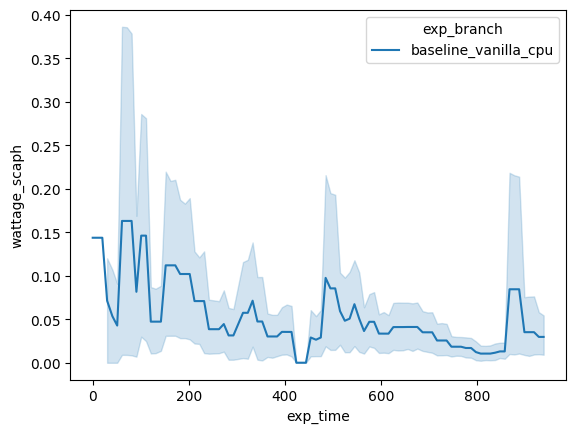

In [53]:
sns.lineplot(data=all_pods,x="exp_time",y="wattage_scaph",hue="exp_branch")

<Axes: xlabel='exp_time', ylabel='wattage_kepler'>

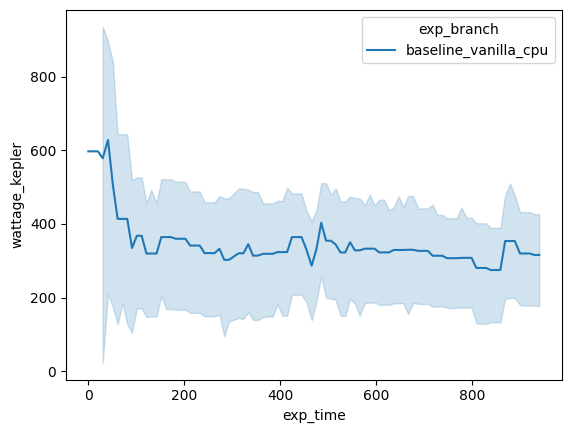

In [54]:
sns.lineplot(data=all_pods,x="exp_time",y="wattage_kepler",hue="exp_branch")

In [55]:
all_pods[(all_pods["instance"] == "unknown") & (all_pods["wattage_scaph"] > 0)][["collection_time","name","instance","wattage_scaph","wattage_kepler"]]

,collection_time,name,instance,wattage_scaph,wattage_kepler
